I recently had to computationally alter some images, an ended up getting interested in some of the basic image manipulation techniques. The result is this post. 

In python, there are a number of powerful libraries that make image processing easy, such as [OpenCV](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_tutorials.html), [SciKit-Image](http://scikit-image.org/) and [Pillow](http://python-pillow.org/). For anyone thinking about doing serious image processing, they should be the first place to look.

However, I am not planning on putting anything into production. Instead the goal of this post is to try and understand the fundamentals of a few simple image processing techniques. Because of this, I am going to stick to using numpy to preform most of the manipulations, although I will use other libraries now and then.

Let's start by loading our libraries

PIL -> np.array
matplotlip
imageio (기능이 별로 없다.)
opencv (좋다. - 비디오)
scipy (좋다 - 근데 약간 lowlevel)
scikit-image (보통 연구하는 사람들이 쓴다. 따라서 알고리즘이 좀 복잡하다.) 

불러와서 넘파이 lowlevel로 처리할 수 있지만, 위 프로그램으로 불러와서 쓸 수 있다. 

In [1]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

And loading our image

In [2]:
im = plt.imread("BTD.jpg")

im.shape 

(4608, 2592, 3)

In [3]:
np.set_numeric_ops # 이미지 options 들이 있다.

<function numpy.set_numeric_ops>

In [4]:
im

array([[[172, 167, 129],
        [178, 173, 135],
        [177, 172, 134],
        ...,
        [176, 171, 142],
        [170, 165, 136],
        [167, 162, 133]],

       [[175, 170, 132],
        [175, 170, 132],
        [171, 166, 128],
        ...,
        [176, 171, 142],
        [172, 167, 138],
        [170, 165, 136]],

       [[170, 165, 127],
        [171, 166, 128],
        [171, 166, 128],
        ...,
        [176, 171, 142],
        [173, 168, 139],
        [171, 165, 139]],

       ...,

       [[216, 204, 180],
        [213, 201, 177],
        [214, 202, 178],
        ...,
        [206, 193, 176],
        [207, 194, 177],
        [208, 195, 178]],

       [[218, 206, 182],
        [214, 202, 178],
        [214, 202, 178],
        ...,
        [208, 195, 178],
        [211, 198, 181],
        [211, 198, 181]],

       [[222, 210, 186],
        [216, 204, 180],
        [215, 203, 179],
        ...,
        [207, 194, 177],
        [212, 199, 182],
        [212, 199, 182]]

We see that image is loaded into an array of dimension 4608 x 2592 x 3.

The first two indices represent the Y and X position of a pixel, and the third represents the RGB colour value of the pixel. Let's take a look at what the image is of

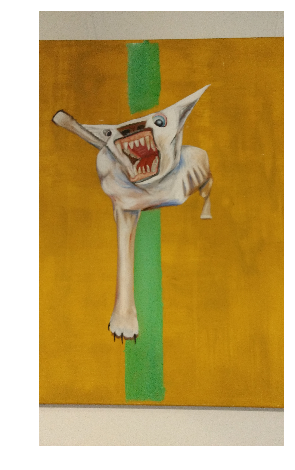

In [34]:
def plti(im, h=8, **kwargs):
    """
    Helper function to plot an image.
    """
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none", **kwargs)
    plt.axis('off') # matplotlib의 축 안보이기 하는 것 

plti(im)

It is a photo of a painting of a dog. The painting itself was found in a flat in London I lived in may years ago, abandoned by its previous owner. I don't know what the story behind it is. If you do, please get in touch. 

We can see that whichever bumbling fool took that photo of the painting also captured a lot of the wall. We can crop the photo so we are only focused on the painting itself. In numpy, this is just a matter of slicing the image array

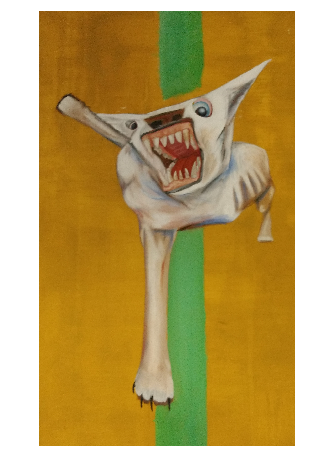

In [38]:
im = im[400:3800,:2000,:]    
plti(im)

# 슬라이싱 5가지 기법 

# Colours

Each pixel of the image is represented by three integers: the RGB value of its colour. Splitting the image into seperate colour components is just a matter of pulling out the correct slice of the image array:

In [11]:
r,g,b = np.split(im, 3, axis=2)

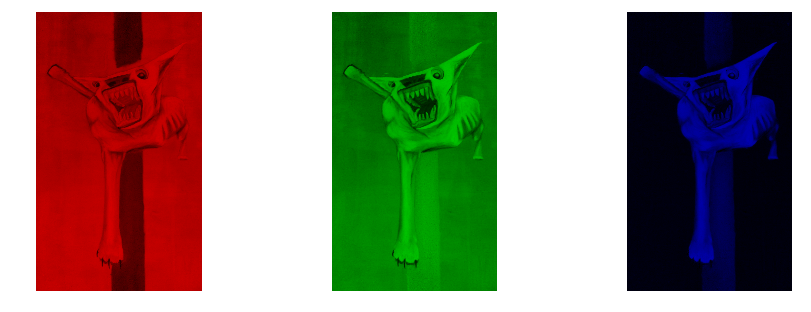

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for c, ax in zip(range(3), axs):
    tmp_im = np.zeros(im.shape, dtype="uint8")
    tmp_im[:,:,c] = im[:,:,c]
    ax.imshow(tmp_im)
    ax.set_axis_off()

When using matplotlib's [imshow](http://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes.imshow) to display images, it is important to keep track of which data type you are using, as the colour mapping used is data type dependent: if a float is used, the values are mapped to the range 0-1, so we need to cast to type "uint8" to get the expected behavior. A good discussion of this issue can be found here [here](http://stackoverflow.com/questions/24739769/matplotlib-imshow-plots-different-if-using-colormap-or-rgb-array).

In my first edition of this post I made this mistake. Thanks to commenter Rusty Chris Holleman for pointing out the problem.


## Colour Transformations
Representing colour in this way, we can think of each pixel as a point in a three dimensional space. Thinking of colour this way, we can apply various transformations to the colour "point". An interesting example of these is "rotating" the colour. 

There is some subtleties - a legal colours officially exist as integer points in a three dimensional cube of side lengths 255. It is possible that a rotation could push a point out of this cube. To get around this I apply a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) transformation to the data, a mapping from the range 0-1 to the full real line. Having applied this transformation we apply the rotation matrix then transform back to colour space. 

The rotation matrix is applied pixel-wise to to the image using numpy's [Einstein notation](https://en.wikipedia.org/wiki/Einstein_notation) function, which I hadn't used before but, but make the operation concise. It is explained well in [this post](https://obilaniu6266h16.wordpress.com/2016/02/04/einstein-summation-in-numpy/).

The following functions apply a sigmoid to the images colour space, and rotate it about the red axis by some angle, before returning the image to normal colour space.  

In [25]:
np.asfarray([1,2,3]).astype('uint8') # float 형태 -> uint8 (영상타입)

array([1, 2, 3], dtype=uint8)

In [26]:
np.asfarray([1,2,3]) @ np.array([1,2,3]) # dot notation

14.0

In [ ]:
# 자동으로 형변환 (type coercion)

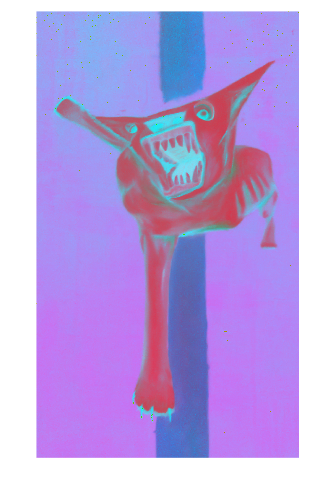

In [7]:
def do_normalise(im):
    return -np.log(1/((1 + im)/257) - 1)
 
def undo_normalise(im):
    return (1 + 1/(np.exp(-im) + 1) * 257).astype("uint8")

def rotation_matrix(theta):
    """
    3D rotation matrix around the X-axis by angle theta
    """
    return np.c_[
        [1,0,0],
        [0,np.cos(theta),-np.sin(theta)],
        [0,np.sin(theta),np.cos(theta)]
    ]

im_normed = do_normalise(im)
im_rotated = np.einsum("ijk,lk->ijl", im_normed, rotation_matrix(np.pi))
im2 = undo_normalise(im_rotated)

plti(im2)

Not bad. It looks even more impressive if we continiously rotate the colour of the pixels. We can animate this transformation using matplotlib's [FuncAnimation](http://matplotlib.org/api/animation_api.html) tool. [This post](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/) has an excellent introduction to how to use it.

In [8]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(5,8))

def update(i):
    im_normed = do_normalise(im)
    im_rotated = np.einsum("ijk,lk->ijl", im_normed, rotation_matrix(i * np.pi/10))
    im2 = undo_normalise(im_rotated)
    
    ax.imshow(im2)
    ax.set_title("Angle: {}*pi/10".format(i), fontsize=20)
    ax.set_axis_off()


anim = FuncAnimation(fig, update, frames=np.arange(0, 20), interval=50)
anim.save('colour_rotation.gif', dpi=80, writer='imagemagick')
plt.close()

# <img src="colour_rotation.gif">

<img src="http://www.degeneratestate.org/static/image-processing-with-numpy/colour_rotation.gif">

psychedelic.

# To Greyscale

On the topic of colour, we can also transform the image to greyscale easily. There are a number of ways to do this, but a straight forward way is to take the weighted mean of the RGB value of original image:

In [2]:
x = np.arange(10).reshape(2,5)

In [3]:
x = np.c_[10,5,2]

In [4]:
a = np.arange(18).reshape(3,2,3, order='C')

In [9]:
b = np.tile(x, (3,2,1))

In [13]:
a

array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]],

       [[12, 13, 14],
        [15, 16, 17]]])

In [11]:
b

array([[[10,  5,  2],
        [10,  5,  2]],

       [[10,  5,  2],
        [10,  5,  2]],

       [[10,  5,  2],
        [10,  5,  2]]], dtype=int32)

In [12]:
np.sum(a*b,axis=2)

array([[  9,  60],
       [111, 162],
       [213, 264]])

In [32]:
def to_grayscale(im, weights = np.c_[0.2989, 0.5870, 0.1140]):
    """
    Transforms a colour image to a greyscale image by
    taking the mean of the RGB values, weighted
    by the matrix weights
    """
    tile = np.tile(weights, reps=(im.shape[0],im.shape[1],1))
    return np.sum(tile * im, axis=2)

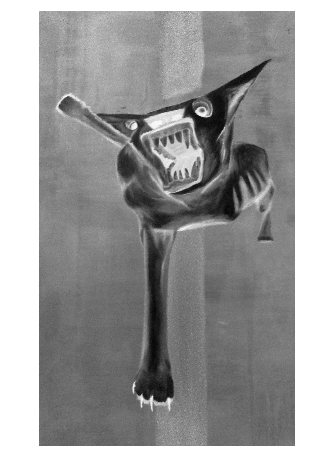

In [39]:
img = to_grayscale(im)

plti(img, cmap='Greys')

# Convoluted

Another of the basic operations you can apply to an image is a convolution. It is defined as

$C(x,y) = \int dx'dy' I(x + x',y + y') W(x',y')$

Where $C$ is the convoluted image, $I$ is the original image and $W$ is a window function. Essentially we are replacing each pixel with a weighted sum of nearby pixels. 

Because convolutions can be expensive, let's start by shrinking the image

In [40]:
from scipy.ndimage.interpolation import zoom
im_small = zoom(im, (0.2,0.2,1))

We can now apply a uniform window to the image. This has the effect of bluring the image, by averaging each pixel with those nearby

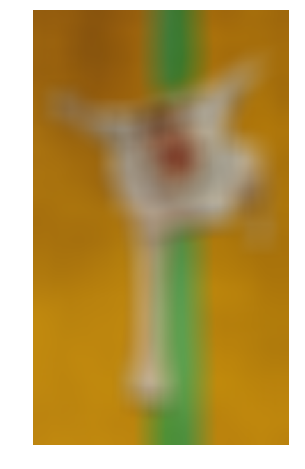

In [42]:
from scipy.signal import convolve2d

def convolve_all_colours(im, window):
    """
    Convolves im with window, over all three colour channels
    """
    ims = []
    for d in range(3):
        im_conv_d = convolve2d(im[:,:,d], window, mode="same", boundary="symm")
        ims.append(im_conv_d)

    im_conv = np.stack(ims, axis=2).astype("uint8")
    
    return im_conv

n=50
window = np.ones((n,n))
window /= np.sum(window)
plti(convolve_all_colours(im_small, window))

For blurring an image, there is a whole host of different windows and functions that can be used. The most common I have found are the uniform window, the Gaussian window and the median filter. To get a feel what these are doing to an image, I apply all of these filters to our image, for different window sizes

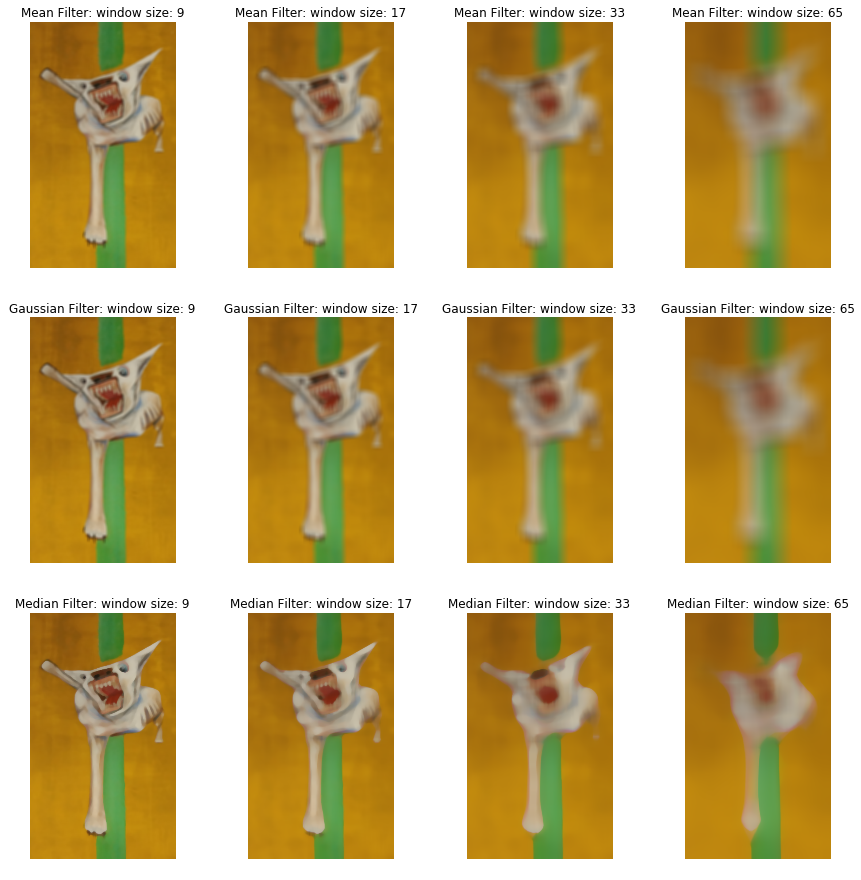

In [13]:
from scipy.ndimage import median_filter

def make_gaussian_window(n, sigma=1):
    """
    Creates a square window of size n by n of weights from a gaussian
    of width sigma.
    """
    nn = int((n-1)/2)
    a = np.asarray([[x**2 + y**2 for x in range(-nn,nn+1)] for y in range(-nn,nn+1)])
    return np.exp(-a/(2*sigma**2))

def median_filter_all_colours(im_small, window_size):
    """
    Applies a median filer to all colour channels
    """
    ims = []
    for d in range(3):
        im_conv_d = median_filter(im_small[:,:,d], size=(window_size,window_size))
        ims.append(im_conv_d)

    im_conv = np.stack(ims, axis=2).astype("uint8") # 채널별로 쌓는다.
    
    return im_conv

window_sizes = [9,17,33,65]
fig, axs = plt.subplots(nrows=3, ncols=len(window_sizes), figsize=(15,15));

# mean filter
for w, ax in zip(window_sizes, axs[0]):
    window = np.ones((w,w))
    window /= np.sum(window)
    ax.imshow(convolve_all_colours(im_small, window));
    ax.set_title("Mean Filter: window size: {}".format(w));
    ax.set_axis_off();
    
# gaussian filter
for w, ax in zip(window_sizes, axs[1]):
    window = make_gaussian_window(w,sigma=w)
    window /= np.sum(window)
    ax.imshow(convolve_all_colours(im_small, window));
    ax.set_title("Gaussian Filter: window size: {}".format(w));
    ax.set_axis_off();
    
# median filter
for w, ax in zip(window_sizes, axs[2]):
    ax.imshow(median_filter_all_colours(im_small, w));
    ax.set_title("Median Filter: window size: {}".format(w));
    ax.set_axis_off();
    


Blurring is only one use of convolutions in image processing. By using more exotic windows, was can extract different kinds of information. The [Sobel filter]() tried to approximate the gradients of the image along one direction using window functions of the form

    [[-1,0,1],
     [-2,0,2],
     [-1,0,1]]

By finding the gradient in both the X and Y directions, and then taking the magnitude of these values we get a map of the gradients in an image for each colour

CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 182 ms


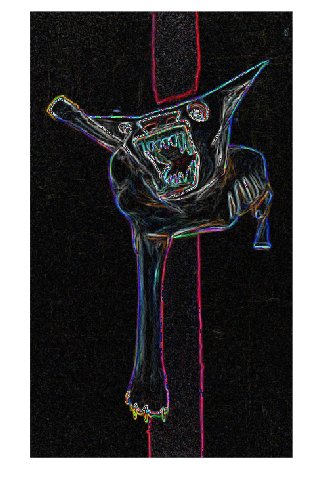

In [14]:
%%time

n=100
sobel_x = np.c_[
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]

sobel_y = np.c_[
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
]

ims = []
for d in range(3):
    sx = convolve2d(im_small[:,:,d], sobel_x, mode="same", boundary="symm")
    sy = convolve2d(im_small[:,:,d], sobel_y, mode="same", boundary="symm")
    ims.append(np.sqrt(sx*sx + sy*sy))

im_conv = np.stack(ims, axis=2).astype("uint8")

plti(im_conv)

The results are pretty impressive. By combining filtering and gradient finding operations together we can generate some strange patterns that resemble the original image but are distorted in interesting ways. The best I have found so far is combining a large window median filter with a Sobel filter

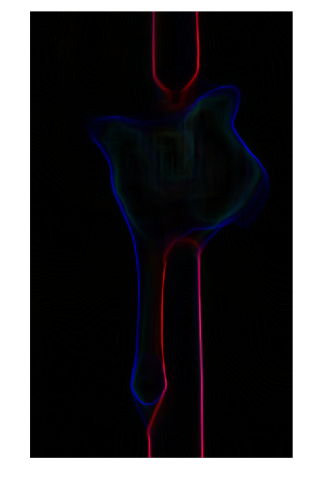

In [15]:
im_smoothed = median_filter_all_colours(im_small, 71)

sobel_x = np.c_[
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]

sobel_y = np.c_[
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
]

ims = []
for d in range(3):
    sx = convolve2d(im_smoothed[:,:,d], sobel_x, mode="same", boundary="symm")
    sy = convolve2d(im_smoothed[:,:,d], sobel_y, mode="same", boundary="symm")
    ims.append(np.sqrt(sx*sx + sy*sy))

im_conv = np.stack(ims, axis=2).astype("uint8")

plti(im_conv)

So far we've looked at applying the same operations to all colour channels at once. If we blur only one colour channel at a time, we get the following eerie effects

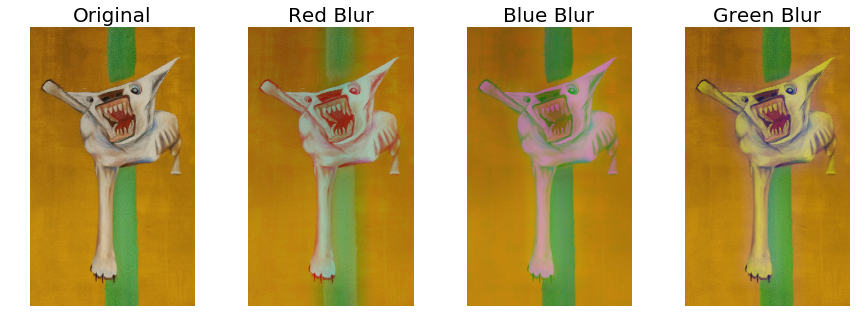

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,5))

ax= axs[0]
ax.imshow(im_small)
ax.set_title("Original", fontsize=20)
ax.set_axis_off()

w=75
window = np.ones((w,w))
window /= np.sum(window)

ax= axs[1]
ims = []
for d in range(3):
    if d == 0:
        im_conv_d = convolve2d(im_small[:,:,d],window, mode="same", boundary="symm")
    else:
        im_conv_d = im_small[:,:,d]
    ims.append(im_conv_d)
ax.imshow(np.stack(ims, axis=2).astype("uint8"))
ax.set_title("Red Blur", fontsize=20)
ax.set_axis_off()

ax= axs[2]
ims = []
for d in range(3):
    if d == 1:
        im_conv_d = convolve2d(im_small[:,:,d], window, mode="same", boundary="symm")
    else:
        im_conv_d = im_small[:,:,d]
    ims.append(im_conv_d)
ax.imshow(np.stack(ims, axis=2).astype("uint8"))
ax.set_title("Blue Blur", fontsize=20)
ax.set_axis_off()

ax= axs[3]
ims = []
for d in range(3):
    if d == 2:
        im_conv_d = convolve2d(im_small[:,:,d], window, mode="same", boundary="symm")
    else:
        im_conv_d = im_small[:,:,d]
    ims.append(im_conv_d)
ax.imshow(np.stack(ims, axis=2).astype("uint8"))
ax.set_title("Green Blur", fontsize=20)
ax.set_axis_off()

# Segmentation

Another major area of image processing is segmenting the image into different regions, for example foreground and background. There are a number of ways to do this, and I will only look at a few here. 

The simplest is to convert the image to greyscale, and find a threshold. Pixels with a value above the threshold are treated as belonging to one region, and below another region. We can explore how different choosing different thresholds segments our greyscale image below

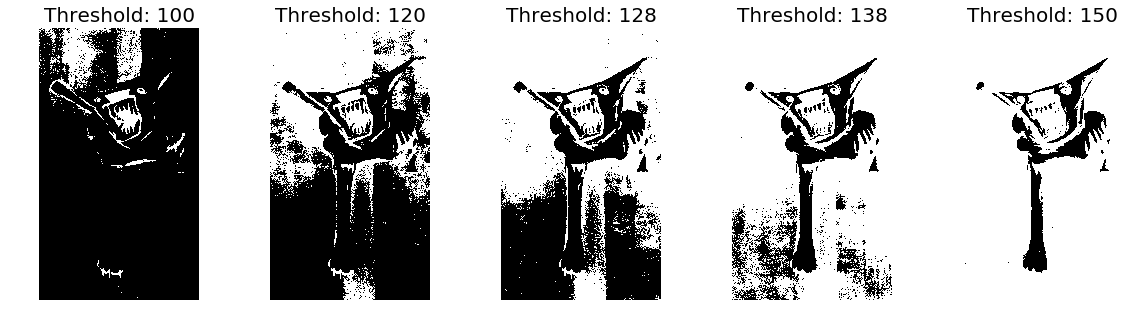

In [47]:
def simple_threshold(im, threshold=128):
    return ((im > threshold) * 255).astype("uint8")

thresholds = [100,120,128,138,150]

fig, axs = plt.subplots(nrows=1, ncols=len(thresholds), figsize=(20,5));
gray_im = to_grayscale(im)
                        
for t, ax in zip(thresholds, axs):
    ax.imshow(simple_threshold(gray_im, t), cmap='Greys');
    ax.set_title("Threshold: {}".format(t), fontsize=20);
    ax.set_axis_off();

How exactly we choose a threshold is going to be application specific. However, we might argue that we would expect the backgroud pixel values to be similar in value to other background pixel values, and the same for the foreground. One way to quantify this is to say that we are looking for the threshold which minimises the inter pixel variance in the foreground and background. One way to calculate this is [Otsu threshold algorithm](), implemented below

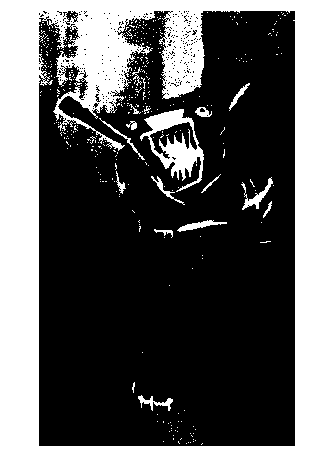

In [48]:
def otsu_threshold(im):

    pixel_counts = [np.sum(im == i) for i in range(256)]

    s_max = (0,-10)
    ss = []
    for threshold in range(256):

        # update
        w_0 = sum(pixel_counts[:threshold])
        w_1 = sum(pixel_counts[threshold:])

        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)]) / w_0 if w_0 > 0 else 0       
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 256)]) / w_1 if w_1 > 0 else 0

        # calculate 
        s = w_0 * w_1 * (mu_0 - mu_1) ** 2
        ss.append(s)

        if s > s_max[1]:
            s_max = (threshold, s)
            
    return s_max[0]

t = otsu_threshold(gray_im)
plti(simple_threshold(gray_im, t), cmap='Greys')

It's not great. However, we might think that by converting our image to greyscale we are throwing away information. We can apply the same process to each colour channel separately to get

C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in long_scalars


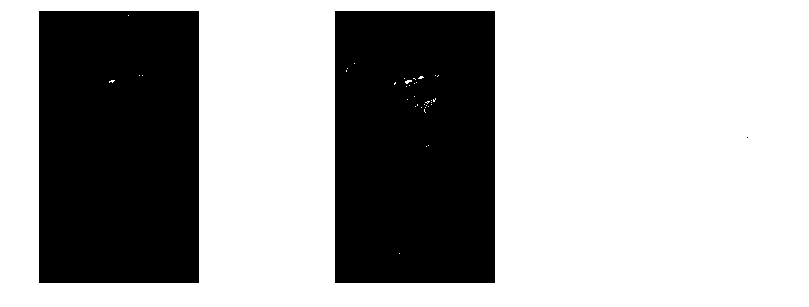

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

c_ims = []
for c, ax in zip(range(3), axs):
    tmp_im = im[:,:,c]
    t = otsu_threshold(tmp_im)
    tmp_im = simple_threshold(tmp_im, t)
    ax.imshow(tmp_im, cmap='Greys')
    c_ims.append(tmp_im)
    ax.set_axis_off()

A natural way to combine each channel into one image is to take the intersection of each thresholded colour channel

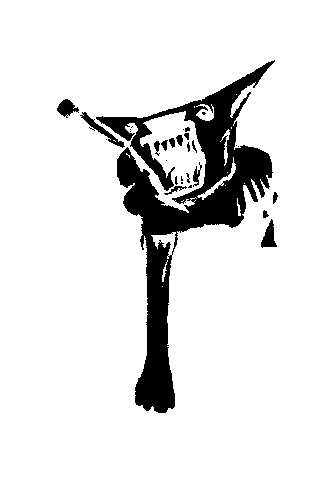

In [19]:
plti(c_ims[0] & c_ims[1] & c_ims[2], cmap='Greys')

Which works much better then just looking at the greyscale image. 

We can be more direct in our approach though. In Otsu thresholding, we found the threshold which minimised the inter-segment pixel variance. If rather then looking for a threshold, we look for clusters in colour space, we end up with the [K-means](https://en.wikipedia.org/wiki/K-means_clustering) clustering technique. Applying this directed to the coloured image, we get

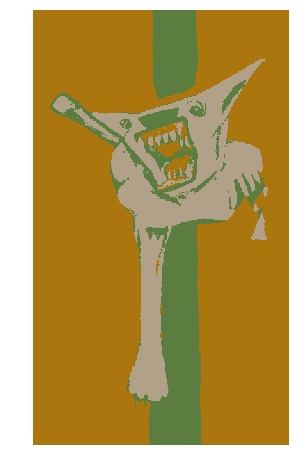

In [51]:
from sklearn.cluster import KMeans

h,w = im_small.shape[:2]
im_small_long = im_small.reshape((h * w, 3))
im_small_wide = im_small_long.reshape((h,w,3))

km = KMeans(n_clusters=3)

km.fit(im_small_long)

cc = km.cluster_centers_.astype(np.uint8)
out = np.asarray([cc[i] for i in km.labels_]).reshape((h,w,3))

plti(out)

Which isn't bad at all. By randomly assigning colours to each of the segments we can create art

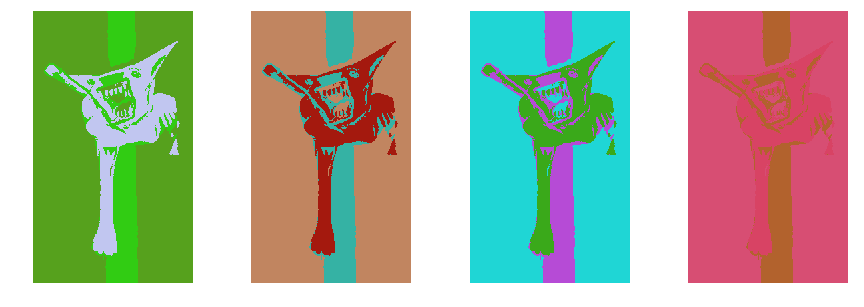

In [52]:
rng = range(4)

fig, axs = plt.subplots(nrows=1, ncols=len(rng), figsize=(15,5))
gray_im = to_grayscale(im)
                        
for t, ax in zip(rng, axs):
    rnd_cc = np.random.randint(0,256, size = (3,3))
    out = np.asarray([rnd_cc[i] for i in km.labels_]).reshape((h,w,3))
    ax.imshow(out)
    ax.set_axis_off()

# Vectorization

So far we have treated an image as a bitmap. As a final step, I am going to extract the segment of the dog from the image, and convert it into a vectorise image.

Let's start by grabbing the segment of the dog:

이미지를 따서 확대 축소를 편하게 할 수 있다. 

In [53]:
list(zip([1,2,3],[4,5,6]))

[(1, 4), (2, 5), (3, 6)]

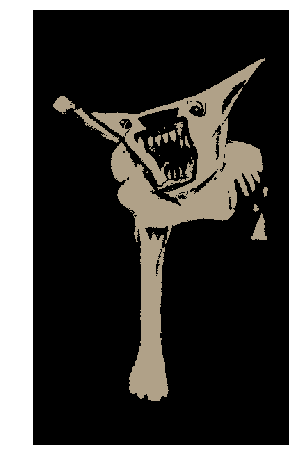

In [54]:
dog = np.asarray([cc[i] if i == 1 else [0,0,0]
                  for i in km.labels_]).reshape((h,w,3))

plti(dog)

We can now use a a contour tracing algorithm from Scikit-Image to extract the paths round the dog

C:\Users\Cho Gyung Ah\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


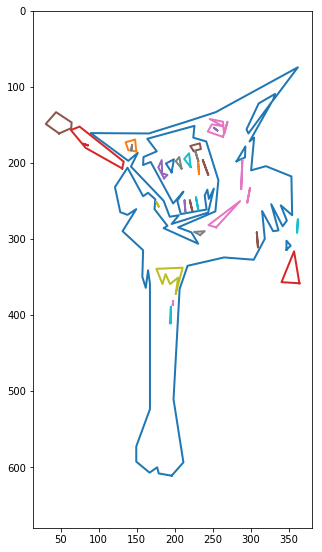

In [55]:
from skimage import measure

seg = np.asarray([(1 if i == 1 else 0)
                  for i in km.labels_]).reshape((h,w))

contours = measure.find_contours(seg, 0.5, fully_connected="high")

simplified_contours = [measure.approximate_polygon(c, tolerance=5) for c in contours]

plt.figure(figsize=(5,10))

for n, contour in enumerate(simplified_contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    
    
plt.ylim(h,0)
plt.axes().set_aspect('equal')

When tracing shapes it it worth playing with the tolerance parameter. This controls how accurately the path follows the original bitmap shape. As our image is fairly noisey, I've turned this up quiet high to "smooth" out the image. The result is a fairly jagged polygons.

To plot the image, we can convert these contour paths to patches and fill them with matplotlib:

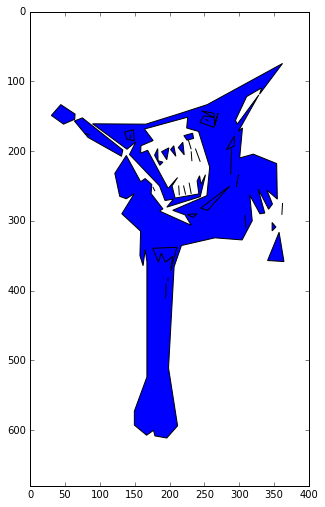

In [27]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path

# flip the path coordinates so it is consistent with matplotlib
paths = [[[v[1], v[0]] for v in vs] for vs in simplified_contours]

def get_path(vs):
    codes = [Path.MOVETO] + [Path.LINETO] * (len(vs)-2) + [Path.CLOSEPOLY]
    return PathPatch(Path(vs, codes))

plt.figure(figsize=(5,10))

ax = plt.gca()

for n, path in enumerate(paths):
    ax.add_patch(get_path(path))


    
plt.ylim(h,0)
plt.xlim(0,w)

plt.axes().set_aspect('equal')

And we run into the problem that some of the contours we've found are not the outside edge of the shape, but the inside edge. To get round this I use the following hackey code. 

We check whether a point is within a polygon using the [ray casting method](https://en.wikipedia.org/wiki/Point_in_polygon), and rely on the fact the for our specific case polygons don't overlap with each other: one polygon is either inside another or not. Finally the subsume function arranges all the polygons into our polygon object, which describes the outside and possible inside edges of the shapes

In [28]:
class Polygon:
    def __init__(self, outer, inners):
        self.outer = outer
        self.inners = inners
        
    def clone(self):
        return Polygon(self.outer[:], [c.clone() for c in self.inners])

def crosses_line(point, line):
    """
    Checks if the line project in the positive x direction from point
    crosses the line between the two points in line
    """
    p1,p2 = line
    
    x,y = point
    x1,y1 = p1
    x2,y2 = p2
    
    if x <= min(x1,x2) or x >= max(x1,x2):
        return False
    
    dx = x1 - x2
    dy = y1 - y2
    
    if dx == 0:
        return True
    
    m = dy / dx

    if y1 + m * (x - x1) <= y:
        return False
    
    return True

def point_within_polygon(point, polygon):
    """
    Returns true if point within polygon
    """
    crossings = 0
    
    for i in range(len(polygon.outer)-1):
        line = (polygon.outer[i], polygon.outer[i+1])
        crossings += crosses_line(point, line)
        
    if crossings % 2 == 0:
        return False
    
    return True

def polygon_inside_polygon(polygon1, polygon2):
    """
    Returns true if the first point of polygon1 is inside 
    polygon 2
    """
    return point_within_polygon(polygon1.outer[0], polygon2)


    
def subsume(original_list_of_polygons):
    """
    Takes a list of polygons and returns polygons with insides.
    
    This function makes the unreasonable assumption that polygons can
    only be complete contained within other polygons (e.g. not overlaps).
    
    In the case where polygons are nested more then three levels, 
    """
    list_of_polygons = [p.clone() for p in original_list_of_polygons]
    polygons_outside = [p for p in list_of_polygons
                        if all(not polygon_inside_polygon(p, p2) 
                               for p2 in list_of_polygons 
                               if p2 != p)]
    
    polygons_inside = [p for p in list_of_polygons
                        if any(polygon_inside_polygon(p, p2) 
                               for p2 in list_of_polygons
                               if p2 != p)]
    
    for outer_polygon in polygons_outside:
        for inner_polygon in polygons_inside:
            if polygon_inside_polygon(inner_polygon, outer_polygon):
                outer_polygon.inners.append(inner_polygon)
                
    return polygons_outside
                
    for p in polygons_outside:
        p.inners = subsume(p.inners)
        
    return polygons_outside

In [29]:
polygons = [Polygon(p,[]) for p in paths]
subsumed_polygons = subsume(polygons)

In [30]:
def build_path_patch(polygon, **kwargs):
    """
    Builds a matplotlb patch to plot a complex polygon described
    by the Polygon class.
    """
    verts = polygon.outer[:]
    codes = [Path.MOVETO] + [Path.LINETO] * (len(verts)-2) + [Path.CLOSEPOLY]

    for inside_path in polygon.inners:
        verts_tmp = inside_path.outer
        codes_tmp = [Path.MOVETO] + [Path.LINETO] * (len(verts_tmp)-2) + [Path.CLOSEPOLY]

        verts += verts_tmp
        codes += codes_tmp

    drawn_path = Path(verts, codes)

    return PathPatch(drawn_path, **kwargs)

Finally we can plot our polygons with a random colour.

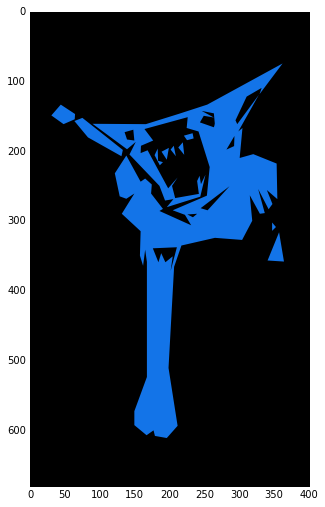

In [31]:
def rnd_color():
    """Returns a randon (R,G,B) tuple"""
    return tuple(np.random.random(size=3))

plt.figure(figsize=(5,10))
ax = plt.gca()  
c = rnd_color()

for n, polygon in enumerate(subsumed_polygons):
    ax.add_patch(build_path_patch(polygon, lw=0, facecolor=c))
    
plt.ylim(h,0)
plt.xlim(0,w)
ax.set_axis_bgcolor('k')
plt.axes().set_aspect('equal')
plt.show()

And with that I'm done. In this post I have only really scratched the surface with what can be done with image processing, but it already feels like I have written a lot, so I'm going to leave it here. For more ideas of what can be done, I suggest looking at the examples of a number of image libraries. 


# This Notebook
The jupyter notebook for this post can be found on github, [here](https://github.com/ijmbarr/image-processing-with-numpy).